In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.model_selection import train_test_split

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# MNIST dataset
train_dataX = np.load('train_data.npy')
test_dataX = np.load('test_data.npy')
train_datay = pd.read_csv('train_labels.csv')

train_datay = train_datay.drop('Id',1)
train_dataX = train_dataX.reshape(-1,100,441,1)
test_dataX = test_dataX.reshape(-1,100,441,1)

x_train, x_test, y_train, y_test = train_test_split(train_dataX,train_datay, test_size=0.1, shuffle=True)

# network parameters
input_shape = (100, 441,1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

In [4]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=(2,3),
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)
print(shape)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
(None, 25, 49, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 100, 441, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 147, 32)  320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 49, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 78400)        0           conv2d_2[0][0]                   
__________________

In [5]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=(2,3),
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 78400)             235200    
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 49, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 147, 64)       36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 100, 441, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 100, 441, 1)       289       
Total params: 290,881
Trainable params: 290,881
Non-trainable params: 0
_________________________________________________________________


In [6]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= 100 * 441
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

# train the autoencoder
vae.fit(x_train, epochs=epochs, batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 100, 441, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 1273300   
_________________________________________________________________
decoder (Model)              (None, 100, 441, 1)       290881    
Total params: 1,564,181
Trainable params: 1,564,181
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 3599 samples, validate on 400 samples
Epoch 1/30
3599/3599 [==============================] - 17s 5ms/step - loss: 264467029.4832 - val_loss: 179.9181
Epoch 2/30
3599/3599 [==============================] - 11s 3ms/step - loss: -9.3341 - val_loss: -152.2547
Epoch 3/30
3599/3599 [==============================] - 11s 3ms/step - loss: -134

From the plot it does seem that gunshots seems to form their own cluster as well as audio that is not gunshot seemed to be cluster together as well

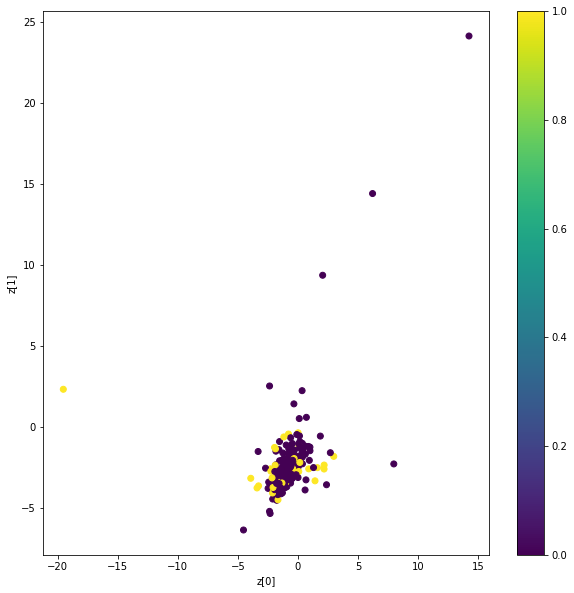

In [8]:
model_name = "VAE_Gunshot"
os.makedirs(model_name, exist_ok=True)

filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean_predict, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(z_mean_predict[:, 0], z_mean_predict[:, 1], c=y_test["Label"])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

**10 x 10 grid of embedding space**

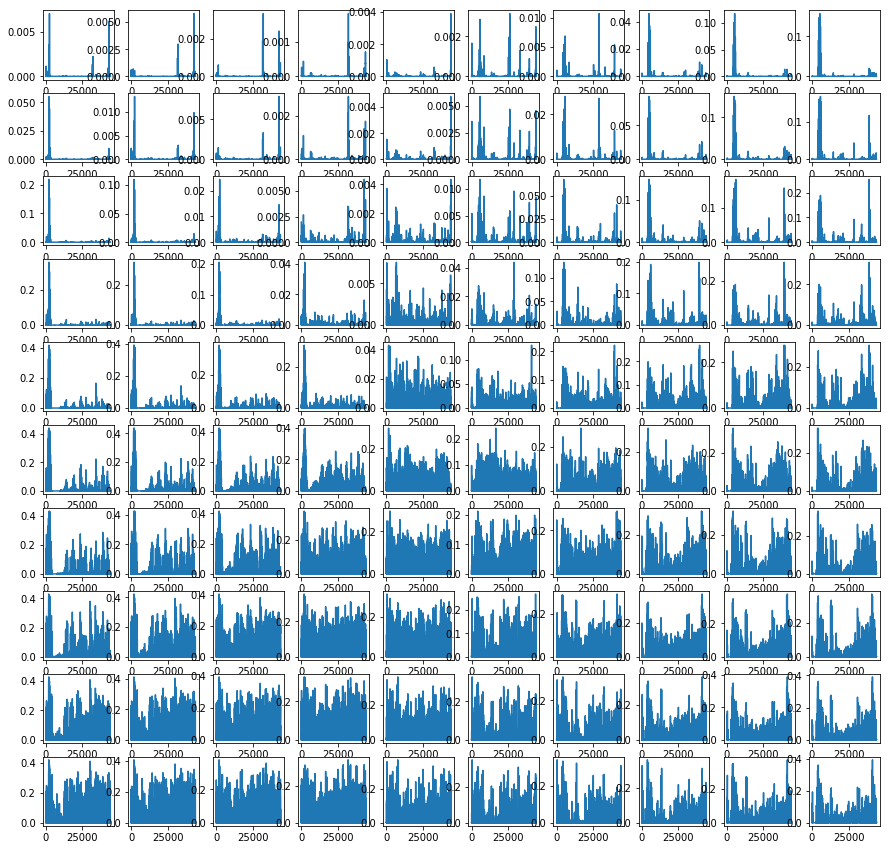

In [9]:
n = 10
digit_size = 44100
figure = np.zeros((digit_size , n, n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)


fig, axs = plt.subplots(n,n,figsize=(15,15))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size)
        figure[:, i, j] = digit
        axs[i,j].plot(digit)

**VAE with larger dimension (using 20 as latent dimensions for embedding space)**

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# MNIST dataset
train_dataX = np.load('train_data.npy')
test_dataX = np.load('test_data.npy')
train_datay = pd.read_csv('train_labels.csv')

train_datay = train_datay.drop('Id',1)
train_dataX = train_dataX.reshape(-1,100,441,1)
test_dataX = test_dataX.reshape(-1,100,441,1)

x_train, x_test, y_train, y_test = train_test_split(train_dataX,train_datay, test_size=0.1, shuffle=True)

# network parameters
input_shape = (100, 441,1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 20
epochs = 30

In [4]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=(2,3),
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)
print(shape)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
(None, 25, 49, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 100, 441, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 147, 32)  320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 25, 49, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 78400)        0           conv2d_2[0][0]                   
__________________

In [5]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=(2,3),
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 78400)             1646400   
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 49, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 147, 64)       36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 100, 441, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 100, 441, 1)       289       
Total params: 1,702,081
Trainable params: 1,702,081
Non-trainable params: 0
_________________________________________________________________


In [6]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= 100 * 441
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

# train the autoencoder
vae.fit(x_train, epochs=epochs, batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 100, 441, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 20), (None, 20),  1273912   
_________________________________________________________________
decoder (Model)              (None, 100, 441, 1)       1702081   
Total params: 2,975,993
Trainable params: 2,975,993
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 3599 samples, validate on 400 samples
Epoch 1/30
3599/3599 [==============================] - 17s 5ms/step - loss: 4719.6720 - val_loss: 177.5116
Epoch 2/30
3599/3599 [==============================] - 11s 3ms/step - loss: -88.1882 - val_loss: 122.6051
Epoch 3/30
3599/3599 [==============================] - 11s 3ms/step - loss: -173.5534

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
z_meanPredict, _, _ = encoder.predict(x_test)

In [16]:
modelRCF = RandomForestClassifier(n_estimators=100, max_depth=8, verbose=1)
modelRCF.fit(z_meanPredict, y_test)

d:\programs\python installed\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [18]:
from sklearn.metrics import roc_auc_score

testing_data, _, _ = encoder.predict(test_dataX)
Y_test_pred = modelRCF.predict_proba(testing_data)
print(Y_test_pred)

[[0.95438922 0.04561078]
 [0.94317627 0.05682373]
 [0.76259826 0.23740174]
 ...
 [0.90924977 0.09075023]
 [0.95963382 0.04036618]
 [0.96544705 0.03455295]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [20]:
pd.DataFrame((Y_test_pred[:,0])).to_csv('submission51.csv', header=["Label"], index_label="Id")